# Helper functions

In [ ]:
BUCKET_NAME="beeflow-dev-metadata-dumps"

In [ ]:
import pandas as pd
import boto3

In [ ]:
s3 = boto3.client('s3') 

In [ ]:
def get_s3_csv(file: str):
    obj = s3.get_object(Bucket=BUCKET_NAME, Key=file)
    return pd.read_csv(obj['Body'])


In [ ]:
from enum import Enum

class System(Enum):
    MWAA = "mwaa"
    BEEFLOW = "serverless"
    
class Stats(Enum):
    DAG_RUNS = "dagrun"
    TASKS = "taskinstance"

In [ ]:
def get_stats(system: System, date: str, stats: Stats):
    return get_s3_csv(f"{system.value}/export/{stats.value}/dt={date}/{stats.value}.csv")

In [ ]:
def filter_on_dag_ids(df, dag_ids):
    return df[df['dag_id'].isin(dag_ids)]

In [ ]:
def filter_on_not_task_ids(df, task_ids):
    return df[~df['task_id'].isin(task_ids)]

In [ ]:
mwaa_shard_10_tasks = filter_on_dag_ids(get_stats(system=System.MWAA, date="2022-12-07_21-57", stats=Stats.TASKS), dag_ids=["beeflow_experiment2"])

In [ ]:
beeflow_shard_10_tasks = filter_on_dag_ids(get_stats(system=System.BEEFLOW, date="2022-12-07_21-50", stats=Stats.TASKS), dag_ids=["beeflow_experiment2"])

In [ ]:
import plotly.express as px

In [ ]:
def gantt_task(df, range_x=None):
    fig = px.timeline(df, x_start="start_date", x_end="end_date", color="run_id", y="task_id", range_x=range_x)
    fig.update_yaxes(autorange="reversed")
    fig.show()

In [ ]:
shard_10_tasks_x_range = ("2022-12-07 20:40:00.000000+00:00", "2022-12-07 21:55:00.000000+00:00")

In [ ]:
gantt_task(mwaa_shard_10_tasks, range_x=shard_10_tasks_x_range)

In [ ]:
gantt_task(beeflow_shard_10_tasks, range_x=shard_10_tasks_x_range)

In [ ]:
mwaa_shard_10_dag_runs = filter_on_dag_ids(get_stats(system=System.MWAA, date="2022-12-07_21-57", stats=Stats.DAG_RUNS), dag_ids=["beeflow_experiment2"])

In [ ]:
beeflow_shard_10_dag_runs = filter_on_dag_ids(get_stats(system=System.BEEFLOW, date="2022-12-07_21-50", stats=Stats.DAG_RUNS), dag_ids=["beeflow_experiment2"])

In [ ]:
def gantt_dag_runs(df, **kwargs):
    fig = px.timeline(df, x_start="start_date", x_end="end_date", color="run_id", **kwargs)
    fig.update_yaxes(autorange="reversed")
    fig.show()

In [ ]:
gantt_dag_runs(mwaa_shard_10_dag_runs, range_x=shard_10_tasks_x_range)

In [ ]:
gantt_dag_runs(beeflow_shard_10_dag_runs, range_x=shard_10_tasks_x_range)

In [ ]:
def average_dag_run_duration(df):
    start_ms_time = pd.to_datetime(df['start_date'])
    end_ms_time = pd.to_datetime(df['end_date'])
    df['duration'] = end_ms_time.sub(start_ms_time).dt.total_seconds()
    return df['duration'].mean()

In [ ]:
average_dag_run_duration(mwaa_shard_10_dag_runs)

In [ ]:
average_dag_run_duration(beeflow_shard_10_dag_runs)

In [ ]:
fig = px.histogram(beeflow_shard_10_dag_runs, x="duration", nbins=20)
fig.show()

In [ ]:
def enhance_with_duration(df):
    start_ms_time = pd.to_datetime(df['start_date'])
    end_ms_time = pd.to_datetime(df['end_date'])
    df['duration'] = end_ms_time.sub(start_ms_time).dt.total_seconds()

In [ ]:
def enhance_with_wait_time_dag_runs(df):
    queued_ms_time = pd.to_datetime(df['queued_at'])
    end_ms_time = pd.to_datetime(df['start_date'])
    df['wait_time'] = end_ms_time.sub(queued_ms_time).dt.total_seconds()

In [ ]:
def enhance_with_wait_time_tasks(df):
    queued_ms_time = pd.to_datetime(df['queued_dttm'])
    end_ms_time = pd.to_datetime(df['start_date'])
    df['wait_time'] = end_ms_time.sub(queued_ms_time).dt.total_seconds()

In [ ]:
def duration_histogram(df, nbins=20):
    fig = px.histogram(df, x="duration", nbins=nbins)
    fig.show()

In [ ]:
def box_plot_duration(beeflow, mwaa):
    beeflow_df = beeflow.loc[:, ['duration']]
    beeflow_df["dataset"] = 'beeflow'
    mwaa_df = mwaa.loc[:, ['duration']]
    mwaa_df["dataset"] = "mwaa"
    fig = px.box(pd.concat([beeflow_df, mwaa_df]), x="dataset", y="duration", points="all")
    fig.show()

In [ ]:
def cross_histogram_plot(beeflow, mwaa, nbins=30, measurment_column_name="duration", **kwargs):
    beeflow_df = beeflow.loc[:, [measurment_column_name]]
    beeflow_df["dataset"] = 'beeflow'
    mwaa_df = mwaa.loc[:, [measurment_column_name]]
    mwaa_df["dataset"] = "mwaa"
    fig = px.histogram(pd.concat([beeflow_df, mwaa_df]), 
                       y=measurment_column_name, 
                       color="dataset", 
                       marginal="box", 
                       barmode="group", 
                       nbins=nbins,
                       **kwargs,
                      )
    fig.show()

In [ ]:
def compare_runs_by_histograms(dag_ids, 
                               mwaa_export_date, 
                               beeflow_export_date, 
                               tasks_num, 
                               task_duration, 
                               nbins=30,
                               not_task_ids=["run_before_loop"]):
    # Draw duration for DAG runs
    mwaa = filter_on_dag_ids(
        df=get_stats(system=System.MWAA, date=mwaa_export_date, stats=Stats.DAG_RUNS), 
        dag_ids=dag_ids
    )
    enhance_with_duration(mwaa)
    beeflow = filter_on_dag_ids(
        df=get_stats(system=System.BEEFLOW, date=beeflow_export_date, stats=Stats.DAG_RUNS), 
        dag_ids=dag_ids
    )
    enhance_with_duration(beeflow)
    cross_histogram_plot(beeflow=beeflow, 
                         mwaa=mwaa, 
                         height=700,
                         title=f"Dag run duration; {task_duration}s task, {tasks_num} tasks",
                         measurment_column_name="duration",
                         nbins=nbins)
    
    # Draw wait time for DAG runs
    enhance_with_wait_time_dag_runs(mwaa)
    enhance_with_wait_time_dag_runs(beeflow)
    cross_histogram_plot(beeflow=beeflow, 
                         mwaa=mwaa, 
                         height=700,
                         title=f"Dag run wait time (start - queued); {task_duration}s task, {tasks_num} tasks",
                         measurment_column_name="wait_time",
                         nbins=nbins)
    
    # Draw duration for tasks
    mwaa_tasks = filter_on_not_task_ids(
        df=filter_on_dag_ids(
            df=get_stats(system=System.MWAA, date=mwaa_export_date, stats=Stats.TASKS), 
            dag_ids=dag_ids
        ), 
        task_ids=not_task_ids,
    )
    enhance_with_duration(mwaa_tasks)
    beeflow_tasks = filter_on_not_task_ids(
        df=filter_on_dag_ids(
            df=get_stats(system=System.BEEFLOW, date=beeflow_export_date, stats=Stats.TASKS), 
            dag_ids=dag_ids
        ), 
        task_ids=not_task_ids,
    )
    enhance_with_duration(beeflow_tasks)
    cross_histogram_plot(beeflow=beeflow_tasks, 
                         mwaa=mwaa_tasks, 
                         height=700,
                         title=f"Tasks duration; {task_duration}s task, {tasks_num} tasks",
                         measurment_column_name="duration",
                         nbins=nbins)
    
    # Draw wait time for tasks
    enhance_with_wait_time_tasks(mwaa_tasks)
    enhance_with_wait_time_tasks(beeflow_tasks)
    cross_histogram_plot(beeflow=beeflow_tasks, 
                     mwaa=mwaa_tasks, 
                     height=700,
                     title=f"Tasks wait time (start - queued); {task_duration}s task, {tasks_num} tasks",
                     measurment_column_name="wait_time",
                     nbins=nbins)


In [ ]:
from dataclasses import dataclass
from typing import List

@dataclass
class HistogramEntry:
    system: System
    export_date: str
    dag_ids: List[str]
    task_duration: int
    tasks_count: int

In [ ]:
@dataclass
class HistogramPlotEntry:
    system: System
    data: pd.DataFrame
    task_duration: int
    tasks_count: int


def cross_histogram_plot_for(entries: List[HistogramPlotEntry], 
                             nbins=30, 
                             measurment_column_name="duration", 
                             **kwargs):
    transformed_data = []
    for entry in entries:
        df = entry.data.loc[:, [measurment_column_name]]
        df["identifier"] = f"{entry.system.value}_tasks:{entry.tasks_count}_duration:{entry.task_duration}"
        transformed_data.append(df)
    fig = px.histogram(pd.concat(transformed_data), 
                       y=measurment_column_name, 
                       color="identifier", 
                       marginal="box", 
                       barmode="group", 
                       nbins=nbins,
                       **kwargs,
                      )
    fig.show()

In [ ]:
def compare_runs_by_histograms_for(entries: List[HistogramEntry], not_task_ids, nbins=30, **kwargs):
    # Draw dags
    dags_data = []
    for entry in entries:
        entry_dag_runs = filter_on_dag_ids(
            df=get_stats(system=entry.system, date=entry.export_date, stats=Stats.DAG_RUNS), 
            dag_ids=entry.dag_ids,
        )
        enhance_with_duration(entry_dag_runs)
        enhance_with_wait_time_dag_runs(entry_dag_runs)
        dags_data.append(
            HistogramPlotEntry(
                system=entry.system,
                data=entry_dag_runs,
                task_duration=entry.task_duration,
                tasks_count=entry.tasks_count,
            )
        )
    cross_histogram_plot_for(dags_data, 
                             nbins, 
                             measurment_column_name="duration", 
                             title="DAG runs comparison: duration",
                             **kwargs)
    cross_histogram_plot_for(dags_data, 
                             nbins, 
                             measurment_column_name="wait_time", 
                             title="DAG run comparision: wait time (start - queued)",
                             **kwargs)
    # Tasks data
    tasks_data = []
    for entry in entries:
        entry_tasks = filter_on_not_task_ids(
            df=filter_on_dag_ids(
                df=get_stats(system=entry.system, date=entry.export_date, stats=Stats.TASKS), 
                dag_ids=entry.dag_ids,
            ),
            task_ids=not_task_ids,
        )
        enhance_with_duration(entry_tasks)
        enhance_with_wait_time_tasks(entry_tasks)
        tasks_data.append(
            HistogramPlotEntry(
                system=entry.system,
                data=entry_tasks,
                task_duration=entry.task_duration,
                tasks_count=entry.tasks_count,
            )
        )
    cross_histogram_plot_for(tasks_data, 
                             nbins, 
                             measurment_column_name="duration", 
                             title="Tasks runs comparison: duration",
                             **kwargs)
    cross_histogram_plot_for(tasks_data, 
                             nbins, 
                             measurment_column_name="wait_time", 
                             title="Tasks run comparision: wait time (start - queued)",
                             **kwargs)
        

In [ ]:
@dataclass
class TasksChartEntry:
    system: System
    export_date: str
    dag_ids: List[str]
    task_duration: int
    tasks_count: int

In [ ]:
def tasks_plot(entry: TasksChartEntry, not_task_ids=[], **kwargs):
    entry_tasks = filter_on_not_task_ids(
        df=filter_on_dag_ids(
            df=get_stats(system=entry.system, date=entry.export_date, stats=Stats.TASKS), 
            dag_ids=entry.dag_ids,
        ),
        task_ids=not_task_ids,
    )
    gantt_task(entry_tasks)
    

# Experiments analysis [parallel tasks, 10s per task]

## MWAA 1min worker, 10 max workers

Run 5 experiments:
- 1 task
- 5 tasks
- 10 tasks
- 15 tasks
- 20 tasks

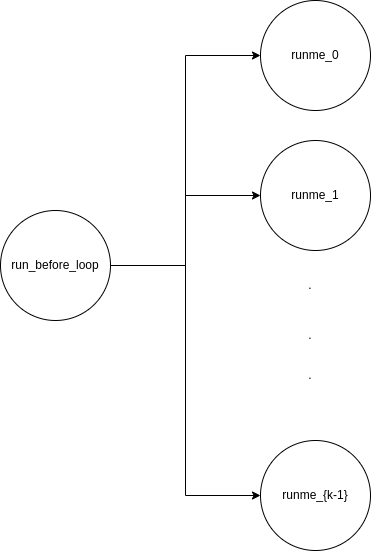


### 1 Task

In [ ]:
compare_runs_by_histograms(
    dag_ids=["10s_1t"],
    mwaa_export_date="2022-12-11_00-08",
    beeflow_export_date="2022-12-10_23-57",
    tasks_num=1,
    task_duration=10,
    nbins=50,
    not_task_ids=[],
)

### 5 tasks in parallel with intro task

In [ ]:
compare_runs_by_histograms(
    dag_ids=["10s_5t"],
    mwaa_export_date="2022-12-11_01-37",
    beeflow_export_date="2022-12-11_01-26",
    tasks_num=5,
    task_duration=10,
    nbins=50,
)

### 10 tasks, 10s per task

In [ ]:
compare_runs_by_histograms(
    dag_ids=["10s_10t"],
    mwaa_export_date="2022-12-11_03-06",
    beeflow_export_date="2022-12-11_02-55",
    tasks_num=10,
    task_duration=10,
    nbins=50,
)

### 15 tasks, 10s per task

In [ ]:
compare_runs_by_histograms(
    dag_ids=["10s_15t"],
    mwaa_export_date="2022-12-11_04-35",
    beeflow_export_date="2022-12-11_04-23",
    tasks_num=15,
    task_duration=10,
    nbins=50,
)

### 20 tasks, 10s per task

In [ ]:
compare_runs_by_histograms(
    dag_ids=["10s_20t"],
    mwaa_export_date="2022-12-11_06-04",
    beeflow_export_date="2022-12-11_05-52",
    tasks_num=20,
    task_duration=10,
    nbins=50,
)

### Diagrams: 5v10v15v20, same pane

In [ ]:
entries = [
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_01-37",
        tasks_count=5,
        task_duration=10,
        dag_ids=["10s_5t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-11_01-26",
        tasks_count=5,
        task_duration=10,
        dag_ids=["10s_5t"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_03-06",
        tasks_count=10,
        task_duration=10,
        dag_ids=["10s_10t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-11_02-55",
        tasks_count=10,
        task_duration=10,
        dag_ids=["10s_10t"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_04-35",
        tasks_count=15,
        task_duration=10,
        dag_ids=["10s_15t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-11_04-23",
        tasks_count=15,
        task_duration=10,
        dag_ids=["10s_15t"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_06-04",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-11_05-52",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"]
    ),
]

In [ ]:
compare_runs_by_histograms_for(entries=entries, not_task_ids=["run_before_loop"], nbins=50, height=700, width=1500)

## MWAA, 1 min worker, 1 max worker (to show scalability)

In [ ]:
entries = [
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-10_19-27",
        tasks_count=5,
        task_duration=10,
        dag_ids=["10s_5t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-10_19-16",
        tasks_count=5,
        task_duration=10,
        dag_ids=["10s_5t"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-10_20-56",
        tasks_count=10,
        task_duration=10,
        dag_ids=["10s_10t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-10_20-45",
        tasks_count=10,
        task_duration=10,
        dag_ids=["10s_10t"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-10_22-25",
        tasks_count=15,
        task_duration=10,
        dag_ids=["10s_15t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-10_22-14",
        tasks_count=15,
        task_duration=10,
        dag_ids=["10s_15t"]
    ),
]

In [ ]:
compare_runs_by_histograms_for(entries=entries, not_task_ids=["run_before_loop"], nbins=50, height=700, width=1500)

# Experiment analysis, line graph, 10s per task

## MWAA 1min worker, 10 max workers

Run 5 experiments:
- 1 task
- 5 tasks
- 10 tasks
- 15 tasks

### 1 task

In [ ]:
compare_runs_by_histograms(
    dag_ids=["10s_1t"],
    mwaa_export_date="2022-12-11_00-08",
    beeflow_export_date="2022-12-10_23-57",
    tasks_num=1,
    task_duration=10,
    nbins=50,
    not_task_ids=[],
)

### 5 tasks

In [ ]:
compare_runs_by_histograms(
    dag_ids=["10s_5t_line"],
    mwaa_export_date="2022-12-11_17-47",
    beeflow_export_date="2022-12-11_17-36",
    tasks_num=5,
    task_duration=10,
    nbins=90,
)

### 10 tasks

In [ ]:
compare_runs_by_histograms(
    dag_ids=["10s_10t_line"],
    mwaa_export_date="2022-12-11_19-16",
    beeflow_export_date="2022-12-11_19-05",
    tasks_num=10,
    task_duration=10,
    nbins=90,
)

### 15 tasks

In [ ]:
compare_runs_by_histograms(
    dag_ids=["10s_15t_line"],
    mwaa_export_date="2022-12-11_20-45",
    beeflow_export_date="2022-12-11_20-33",
    tasks_num=15,
    task_duration=10,
    nbins=90,
)

## 1v5v10v15 

In [ ]:
entries = [
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_17-47",
        tasks_count=5,
        task_duration=10,
        dag_ids=["10s_5t_line"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-11_17-36",
        tasks_count=5,
        task_duration=10,
        dag_ids=["10s_5t_line"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_19-16",
        tasks_count=10,
        task_duration=10,
        dag_ids=["10s_10t_line"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-11_19-05",
        tasks_count=10,
        task_duration=10,
        dag_ids=["10s_10t_line"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_20-45",
        tasks_count=15,
        task_duration=10,
        dag_ids=["10s_15t_line"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-11_20-33",
        tasks_count=15,
        task_duration=10,
        dag_ids=["10s_15t_line"]
    ),
]

In [ ]:
compare_runs_by_histograms_for(entries=entries, not_task_ids=["run_before_loop"], nbins=50, height=700, width=1500)

# Random comparisons

## Beeflow 5v10v20v40

In [ ]:
entries = [
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-11_01-26",
        tasks_count=5,
        task_duration=10,
        dag_ids=["10s_5t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-11_02-55",
        tasks_count=10,
        task_duration=10,
        dag_ids=["10s_10t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-11_05-52",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-13_22-02",
        tasks_count=40,
        task_duration=10,
        dag_ids=["10s_40t"]
    ),
]

In [ ]:
compare_runs_by_histograms_for(entries=entries, not_task_ids=["run_before_loop"], nbins=50, height=700, width=1500)

# 10 min cron, MWAA vs Beeflow (scales to 10 workers); Cold starts!

In [ ]:
entries = [
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-14_17-04",
        tasks_count=10,
        task_duration=10,
        dag_ids=["10s_10t_10cron"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-14_17-15",
        tasks_count=10,
        task_duration=10,
        dag_ids=["10s_10t_10cron"]
    ),
]

In [ ]:
compare_runs_by_histograms_for(entries=entries, not_task_ids=["run_before_loop"], nbins=50, height=700, width=1500)

# DMS CDC 5v10v15v20

In [ ]:
entries = [
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-24_11-25",
        tasks_count=5,
        task_duration=10,
        dag_ids=["10s_5t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-24_12-44",
        tasks_count=10,
        task_duration=10,
        dag_ids=["10s_10t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-24_14-04",
        tasks_count=15,
        task_duration=10,
        dag_ids=["10s_15t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-24_15-23",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"]
    ),
]

In [ ]:
compare_runs_by_histograms_for(entries=entries, not_task_ids=["run_before_loop"], nbins=50, height=700, width=1500)

In [ ]:
entry = TasksChartEntry(
        system=System.BEEFLOW,
        export_date="2022-12-24_15-23",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"]
    )

tasks_plot(entry)

In [ ]:
entry_dag_runs = filter_on_dag_ids(
    df=get_stats(system=entry.system, date=entry.export_date, stats=Stats.DAG_RUNS), 
    dag_ids=entry.dag_ids,
)
enhance_with_duration(entry_dag_runs)
entry_dag_runs[["duration", "run_id", "start_date", "end_date"]]

# DMS CDC vs MWAA parallel

In [ ]:
entries = [
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_01-37",
        tasks_count=5,
        task_duration=10,
        dag_ids=["10s_5t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-24_11-25",
        tasks_count=5,
        task_duration=10,
        dag_ids=["10s_5t"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_03-06",
        tasks_count=10,
        task_duration=10,
        dag_ids=["10s_10t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-24_12-44",
        tasks_count=10,
        task_duration=10,
        dag_ids=["10s_10t"]
    ),
     HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_04-35",
        tasks_count=15,
        task_duration=10,
        dag_ids=["10s_15t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-24_14-04",
        tasks_count=15,
        task_duration=10,
        dag_ids=["10s_15t"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_06-04",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-24_15-23",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"]
    ),
]

In [ ]:
compare_runs_by_histograms_for(entries=entries, not_task_ids=["run_before_loop"], nbins=50, height=700, width=1500)

# DMS CDC 1 vs MWAA 1

In [ ]:
entries = [
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_00-08",
        tasks_count=1,
        task_duration=10,
        dag_ids=["10s_1t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-24_10-05",
        tasks_count=1,
        task_duration=10,
        dag_ids=["10s_1t"]
    ),
]

In [ ]:
compare_runs_by_histograms_for(entries=entries, not_task_ids=[], nbins=50, height=700, width=1500)

# DMS CDC linear 5v10v25

In [ ]:
entries = [
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_17-47",
        tasks_count=5,
        task_duration=10,
        dag_ids=["10s_5t_line"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-28_13-52",
        tasks_count=5,
        task_duration=10,
        dag_ids=["10s_5t_line"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_19-16",
        tasks_count=10,
        task_duration=10,
        dag_ids=["10s_10t_line"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-28_15-24",
        tasks_count=10,
        task_duration=10,
        dag_ids=["10s_10t_line"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2022-12-11_20-45",
        tasks_count=15,
        task_duration=10,
        dag_ids=["10s_15t_line"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2022-12-28_16-43",
        tasks_count=15,
        task_duration=10,
        dag_ids=["10s_15t_line"]
    ),
]

In [ ]:
compare_runs_by_histograms_for(entries=entries, not_task_ids=[], nbins=50, height=700, width=1500)

In [ ]:
entry = TasksChartEntry(
        system=System.BEEFLOW,
        export_date="2022-12-28_16-43",
        tasks_count=15,
        task_duration=10,
        dag_ids=["10s_15t_line"]
    )

tasks_plot(entry)

In [ ]:
entry = TasksChartEntry(
        system=System.MWAA,
        export_date="2022-12-11_20-45",
        tasks_count=15,
        task_duration=10,
        dag_ids=["10s_15t_line"]
    )

tasks_plot(entry)

In [ ]:
entry = TasksChartEntry(
        system=System.BEEFLOW,
        export_date="2022-12-24_15-23",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"]
    )

entry_dag_runs = filter_on_dag_ids(
    df=get_stats(system=entry.system, date=entry.export_date, stats=Stats.DAG_RUNS), 
    dag_ids=entry.dag_ids,
)
enhance_with_duration(entry_dag_runs)

In [ ]:
entry_dag_runs[["duration", "run_id", "start_date", "end_date", "_state"]]

In [ ]:
entry = TasksChartEntry(
        system=System.BEEFLOW,
        export_date="2022-12-13_22-02",
        tasks_count=40,
        task_duration=10,
        dag_ids=["10s_40t"]
    )

tasks_plot(entry)

# Beeflow vs MWAA

In [ ]:
entries = [
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_17-28",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_18-57",
        tasks_count=40,
        task_duration=10,
        dag_ids=["10s_40t"]
    ),
]

In [ ]:
entry = TasksChartEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_20-26",
        tasks_count=80,
        task_duration=10,
        dag_ids=["10s_80t"]
    )

entry_dag_runs = filter_on_dag_ids(
    df=get_stats(system=entry.system, date=entry.export_date, stats=Stats.DAG_RUNS), 
    dag_ids=entry.dag_ids,
)
enhance_with_duration(entry_dag_runs)

In [ ]:
f

In [ ]:
entry = TasksChartEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_20-26",
        tasks_count=80,
        task_duration=10,
        dag_ids=["10s_80t"]
    )

tasks_plot(entry)

In [ ]:
entry_dag_runs[["duration", "run_id", "start_date", "end_date", "_state"]]

In [ ]:
entries = [
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_17-28",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2023-01-07_17-39",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_18-57",
        tasks_count=40,
        task_duration=10,
        dag_ids=["10s_40t"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2023-01-07_19-09",
        tasks_count=40,
        task_duration=10,
        dag_ids=["10s_40t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_20-26",
        tasks_count=80,
        task_duration=10,
        dag_ids=["10s_80t"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2023-01-07_20-38",
        tasks_count=80,
        task_duration=10,
        dag_ids=["10s_80t"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_21-55",
        tasks_count=160,
        task_duration=10,
        dag_ids=["10s_160t"]
    ),
    HistogramEntry(
        system=System.MWAA,
        export_date="2023-01-07_22-07",
        tasks_count=160,
        task_duration=10,
        dag_ids=["10s_160t"]
    ),
]

In [ ]:
compare_runs_by_histograms_for(entries=entries, not_task_ids=[], nbins=50, height=700, width=1500)

# Coldstarts

In [ ]:
entries = [
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2023-01-08_16-35",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t_30cron"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2023-01-08_18-35",
        tasks_count=40,
        task_duration=10,
        dag_ids=["10s_40t_30cron"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2023-01-08_20-36",
        tasks_count=80,
        task_duration=10,
        dag_ids=["10s_80t_30cron"]
    ),
    HistogramEntry(
        system=System.BEEFLOW,
        export_date="2023-01-08_22-38",
        tasks_count=160,
        task_duration=10,
        dag_ids=["10s_160t_30cron"]
    ),
]

In [ ]:
compare_runs_by_histograms_for(entries=entries, not_task_ids=[], nbins=50, height=700, width=1500)